# Compare MCMC with BBVI 

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import os

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import liesel.goose as gs
import liesel.model as lsl
from liesel.distributions.mvn_degen import MultivariateNormalDegenerate as LieselMultivariateNormalDegenerate
from liesel.goose.types import Array

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate as TigerpyMultivariateNormalDegenerate

# Use distributions from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

In [2]:
import simulation.sim_fun.sim_data as sim_data

In [3]:
key = jax.random.PRNGKey(27)
data = sim_data.normal_complex_const(n_obs=1000, 
                                     key=key)

In [4]:
data["data"]

,loc,scale,x,y
0,2.305559,1.5,-8.649616,1.715355
1,1.661334,1.5,6.863830,-3.020366
2,4.516452,1.5,0.698824,2.778883
3,4.280604,1.5,4.736071,4.578554
4,4.359221,1.5,5.690248,4.556962
...,...,...,...,...
995,3.417524,1.5,-4.028184,1.717327
996,3.977503,1.5,0.395110,3.536832
997,2.250917,1.5,8.082693,0.695695
998,3.885910,1.5,5.929310,3.947482


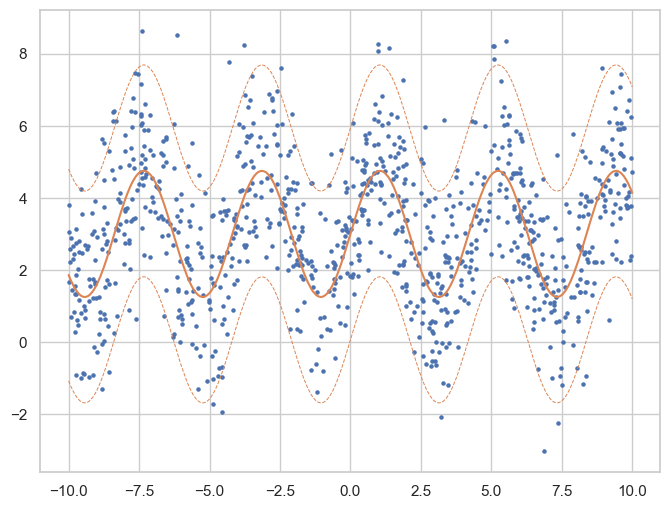

In [5]:
sim_data.plot_sim_data(data["data"], dist="normal")

## Fit from BBVI

In [6]:
# Preprocess data 
x = data["data"]["x"]
y = data["data"]["y"]

In [7]:
# Define a model with intercept 
# Set up design matrix 
X = tiger.Obs(name="X", intercept=True)
X.smooth(data=x)
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
X.center()

# Fixed coefficents 
# Set up beta_fixed hyperparameters 
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=0.0, distribution=beta_dist, name="beta")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
tau2_a = tiger.Hyper(1.0, name="tau2_a")
tau2_b = tiger.Hyper(0.00005, name="tau2_b")
tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau2_a, scale=tau2_b)
tau2 = tiger.Param(value=jnp.array([1.0]), distribution=tau2_dist, param_space="positive", name="tau2")

# Smooth coefficients
# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
gamma_loc = tiger.Hyper(jnp.zeros(X.smooth_dim_cent[0]), name="gamma_loc")

# Define the penalty matrix 
gamma_pen = tiger.Hyper(X.smooth_pen_mat_cent[0], name="gamma_pen")

# Set up parameters
gamma_dist = tiger.Dist(TigerpyMultivariateNormalDegenerate, loc=gamma_loc, var=tau2, pen=gamma_pen)
gamma = tiger.Param(value=jnp.zeros(X.smooth_dim_cent[0]), distribution=gamma_dist, name="gamma")

# Set up the linear predictor
lpred = tiger.Lpred(obs=X, beta=beta, gamma=gamma)

# Set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=y.to_numpy(), distribution=response_dist)

In [8]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

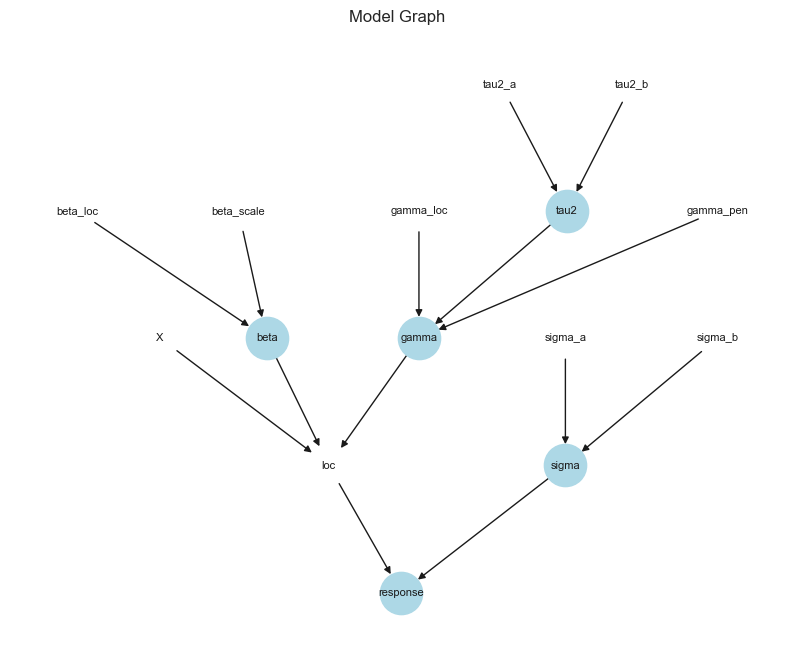

In [9]:
graph.visualize_graph()

In [10]:
q = bbvi.Bbvi(graph=graph)
key, subkey = jax.random.split(key)

In [11]:
q.run_bbvi(key=subkey,
           learning_rate=0.01,
           grad_clip=1,
           threshold=1e-2,
           batch_size=256,
           num_var_samples=64,
           chunk_size=50,
           epochs=500)

Start optimization ...
Finished optimization.


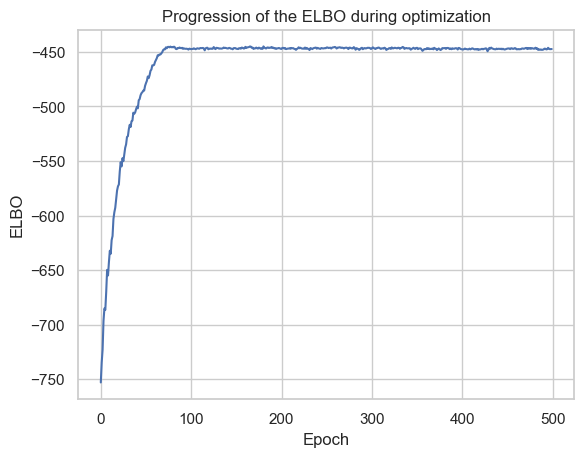

In [12]:
q.plot_elbo()

In [13]:
q.return_loc_params

{'beta': {'loc': Array([3.0885634], dtype=float32)},
 'tau2': {'loc': Array([6.4534254], dtype=float32)},
 'sigma': {'loc': Array([1.5599554], dtype=float32)},
 'gamma': {'loc': Array([ 1.3888104 ,  0.97967625, -1.4604378 , -2.2792158 ,  1.0286144 ,
          2.2917788 ,  0.41673484, -2.0109024 , -1.2108204 ,  1.1586452 ,
          2.4564128 , -0.5854715 , -2.2702591 , -1.1778705 ,  1.6917117 ,
          1.5870575 , -0.6734651 , -0.99766517, -0.46256   ], dtype=float32)}}

In [14]:
beta = q.trans_var_params["beta"]["loc"]
gamma = q.trans_var_params["gamma"]["loc"]
loc_param = jnp.concatenate((beta, gamma))
y_opt = X.design_matrix @ loc_param

In [15]:
pred_data_tiger = pd.DataFrame({"x": x, "y":y_opt})
sort_pred_data_tiger = pred_data_tiger.sort_values("x")

In [16]:
sort_df = data["data"].sort_values("x")

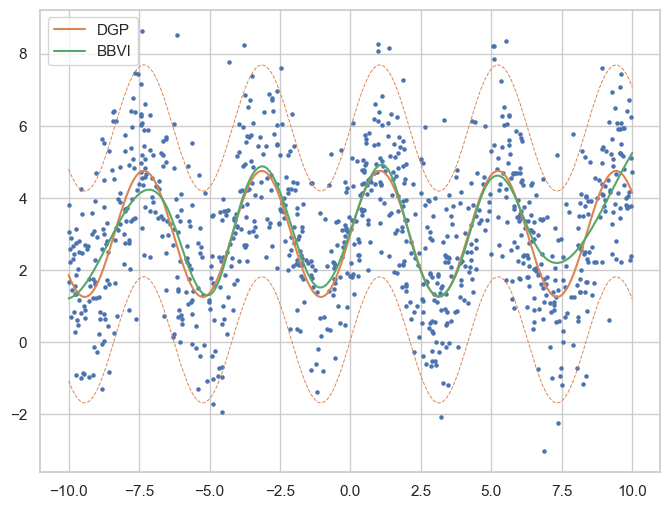

In [17]:
# plot the data
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

plt.scatter(x=sort_df["x"], y=sort_df["y"], s=5)
plt.plot(sort_df["x"], sort_df["loc"], label="DGP", color=sns.color_palette()[1])
plt.plot(sort_df["x"], sort_df["loc"] + 1.96*sort_df["scale"], linewidth=0.7, color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_df["x"], sort_df["loc"] - 1.96*sort_df["scale"], linewidth=0.7, color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y"], color=sns.color_palette()[2], label = "BBVI")
plt.legend()
plt.show()

sns.reset_orig()

## Fit from liesel

In [18]:
# Define Groups for the smooth parameter priors
class VarianceIG(lsl.Group):
    def __init__(
        self, name: str, a: float, b: float, start_value: float = 1000.0
    ) -> None:
        a_var = lsl.Var(a, name=f"{name}_a")
        b_var = lsl.Var(b, name=f"{name}_b")

        prior = lsl.Dist(tfjd.InverseGamma, concentration=a_var, scale=b_var)
        tau2 = lsl.param(start_value, distribution=prior, name=name)
        super().__init__(name=name, a=a_var, b=b_var, tau2=tau2)

class SplineCoef(lsl.Group):
    def __init__(self, name: str, penalty: Array, tau2: lsl.param) -> None:
        penalty_var = lsl.Var(penalty, name=f"{name}_penalty")

        evals = jax.numpy.linalg.eigvalsh(penalty)
        rank = lsl.Data(jnp.sum(evals > 0.0), _name=f"{name}_rank")
        _log_pdet = jnp.log(jnp.where(evals > 0.0, evals, 1.0)).sum()
        log_pdet = lsl.Data(_log_pdet, _name=f"{name}_log_pdet")

        prior = lsl.Dist(
            LieselMultivariateNormalDegenerate.from_penalty,
            loc=0.0,
            var=tau2,
            pen=penalty_var,
            rank=rank,
            log_pdet=log_pdet
        )
        start_value = np.zeros(np.shape(penalty)[-1], np.float32)

        coef = lsl.param(start_value, distribution=prior, name=name)

        super().__init__(name, coef=coef, penalty=penalty_var, tau2=tau2, rank=rank)

class PSpline(lsl.Group):
    def __init__(
        self, name, basis_matrix: Array, penalty: Array, tau2_group: lsl.Group
    ) -> None:
        coef_group = SplineCoef(
            name=f"{name}_coef", penalty=penalty, tau2=tau2_group["tau2"]
        )

        basis_matrix = lsl.obs(basis_matrix, name="basis_matrix")
        smooth = lsl.Var(
            lsl.Calc(jnp.dot, basis_matrix, coef_group["coef"]), name=name
        )

        group_vars = coef_group.nodes_and_vars | tau2_group.nodes_and_vars

        super().__init__(
            name=name,
            basis_matrix=basis_matrix,
            smooth=smooth,
            **group_vars
        )

In [19]:
# Set up model in liesel
# Fixed parameter prior
beta_loc = lsl.Var(0.0, name="beta_loc")
beta_scale = lsl.Var(100.0, name="beta_scale")

# Set up the fixed parameters
beta_dist = lsl.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = lsl.param(value=np.array([0.0]), distribution=beta_dist, name="beta")

# Set up the smooth parameters
tau2_group = VarianceIG(name="tau2", a=1.0, b=0.00005)

penalty = X.smooth_pen_mat_cent[0]
smooth_group_1 = PSpline(name="smooth_1", basis_matrix=X.design_mat_cent[1], penalty=penalty, tau2_group=tau2_group)

# Set up the scale 
sigma_a = lsl.Var(0.01, name="sigma_a")
sigma_b = lsl.Var(0.01, name="sigma_b")

sigma_dist = lsl.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = lsl.param(value=10.0, distribution=sigma_dist, name="sigma")

Z = lsl.obs(X.fixed_data, name="Z")

lpred_loc_fn = lambda z, beta, smooth_1: jnp.dot(z, beta) + smooth_1
lpred_loc_calc = lsl.Calc(lpred_loc_fn, z=Z, beta=beta, smooth_1=smooth_group_1["smooth"])

lpred_loc = lsl.Var(lpred_loc_calc, name="lpred_loc")

response_dist = lsl.Dist(tfjd.Normal, loc=lpred_loc, scale=sigma)
response = lsl.Var(y.to_numpy(), distribution=response_dist, name="response")

In [20]:
gb = lsl.GraphBuilder().add(response)
gb.transform(sigma, tfjb.Exp)

liesel.model.model - INFO - Converted dtype of Data(name="smooth_1_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="beta_value").value
liesel.model.model - INFO - Converted dtype of Data(name="Z_value").value


Var(name="sigma_transformed")

In [21]:
model = gb.build_model()

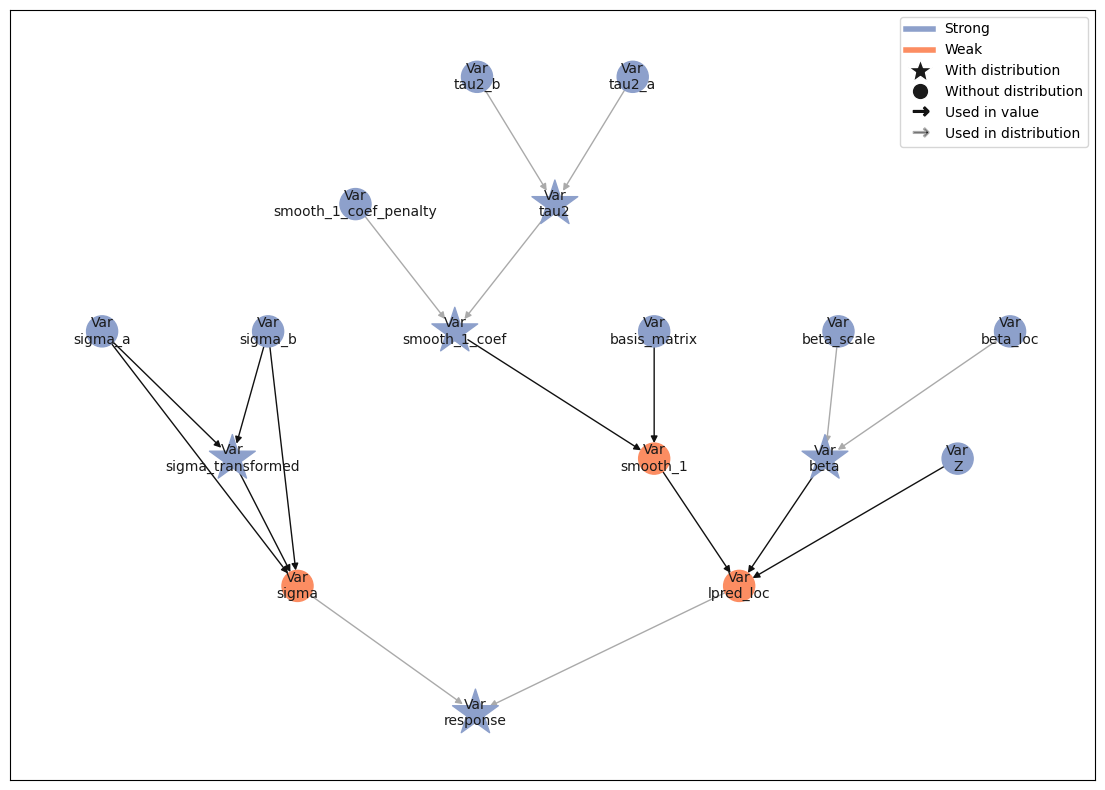

In [22]:
lsl.plot_vars(model)

In [23]:
def tau2_gibbs_kernel(p_spline: PSpline) -> gs.GibbsKernel:
    """Builds a Gibbs kernel for a smoothing parameter with an inverse gamma prior."""
    position_key = p_spline["tau2"].name

    def transition(prng_key, model_state):
        a_prior = p_spline.value_from(model_state, "a")
        b_prior = p_spline.value_from(model_state, "b")

        rank = p_spline.value_from(model_state, "rank")
        K = p_spline.value_from(model_state, "penalty")

        beta = p_spline.value_from(model_state, "coef")

        a_gibbs = jnp.squeeze(a_prior + 0.5 * rank)
        b_gibbs = jnp.squeeze(b_prior + 0.5 * (beta @ K @ beta))

        draw = b_gibbs / jax.random.gamma(prng_key, a_gibbs)

        return {position_key: draw}

    return gs.GibbsKernel([position_key], transition)

In [25]:
key, subkey = jax.random.split(key)
builder = gs.EngineBuilder(seed=subkey, num_chains=4)

builder.set_model(gs.LieselInterface(model))
builder.set_initial_values(model.state)

builder.add_kernel(tau2_gibbs_kernel(smooth_group_1))
builder.add_kernel(gs.IWLSKernel(["smooth_1_coef"]))
builder.add_kernel(gs.IWLSKernel(["beta"]))
builder.add_kernel(gs.NUTSKernel(["sigma_transformed"]))

builder.set_duration(warmup_duration=1000, posterior_duration=1000)

builder.positions_included = ["sigma"]

engine = builder.build()

engine._show_progress = False

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...


liesel.goose.engine - INFO - Done


In [26]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Finished warmup


In [27]:
results = engine.get_results()
gs.Summary(results)

Parameter summary:

                            kernel      mean        sd    q_0.05     q_0.5  \
parameter         index                                                      
beta              (0,)   kernel_02  3.097327  0.047806  3.020863  3.096249   
sigma             ()             -  1.520213  0.034541  1.464617  1.519919   
sigma_transformed ()     kernel_03  0.418593  0.022702  0.381594  0.418657   
smooth_1_coef     (0,)   kernel_01  1.952196  0.214786  1.606381  1.950161   
                  (1,)   kernel_01  1.515120  0.237040  1.125374  1.514806   
                  (2,)   kernel_01 -2.011433  0.360484 -2.613746 -2.013319   
                  (3,)   kernel_01 -2.370647  0.383370 -2.990328 -2.373768   
                  (4,)   kernel_01  1.088328  0.368618  0.471600  1.091071   
                  (5,)   kernel_01  2.414791  0.451916  1.692286  2.416061   
                  (6,)   kernel_01  0.713453  0.397643  0.073535  0.702687   
                  (7,)   kernel_01 -2.075702  0.450824 -2.836551 -2.074514   
                  (8,)   kernel_01 -1.180514  0.380414 -1.810403 -1.183035   
                  (9,)   kernel_01  1.171658  0.355954  0.573534  1.172688   
                  (10,)  kernel_01  2.528562  0.395778  1.903989  2.516416   
                  (11,)  kernel_01 -0.716949  0.413967 -1.396206 -0.710946   
                  (12,)  kernel_01 -2.084702  0.343951 -2.654479 -2.083958   
                  (13,)  kernel_01 -0.966994  0.406203 -1.620672 -0.977772   
                  (14,)  kernel_01  1.567854  0.458292  0.820325  1.567216   
                  (15,)  kernel_01  2.232596  0.318434  1.726427  2.223731   
                  (16,)  kernel_01 -1.645144  0.214652 -2.010233 -1.644456   
                  (17,)  kernel_01 -1.888465  0.205540 -2.229603 -1.887990   
                  (18,)  kernel_01 -0.635630  0.191866 -0.949180 -0.642034   
tau2              ()     kernel_00  9.190762  3.610705  4.875317  8.448554   

                            q_0.95  sample_size     ess_bulk     ess_tail  \
parameter         index                                                     
beta              (0,)    3.177070         4000  1365.295336  2263.131813   
sigma             ()      1.578366         4000  1507.327440  1892.435553   
sigma_transformed ()      0.456390         4000  1507.326595  1892.435553   
smooth_1_coef     (0,)    2.310051         4000   444.984571   849.645115   
                  (1,)    1.904739         4000   341.105606   840.600003   
                  (2,)   -1.420025         4000   352.639211   699.412771   
                  (3,)   -1.733299         4000   443.393738   737.287169   
                  (4,)    1.691190         4000   389.219146  1000.597001   
                  (5,)    3.167396         4000   334.111097   693.933648   
                  (6,)    1.380022         4000   357.017624   577.685545   
                  (7,)   -1.336714         4000   367.326222   773.996228   
                  (8,)   -0.553656         4000   446.639653   883.616033   
                  (9,)    1.769953         4000   319.137914   707.380875   
                  (10,)   3.212465         4000   401.636318   604.533533   
                  (11,)  -0.041922         4000   328.987939   824.139824   
                  (12,)  -1.515047         4000   403.683529   763.323340   
                  (13,)  -0.292379         4000   390.036713   797.138123   
                  (14,)   2.316590         4000   379.404015   712.048180   
                  (15,)   2.760612         4000   372.649566   945.444337   
                  (16,)  -1.299066         4000   355.705253   731.186835   
                  (17,)  -1.553537         4000   322.804111   753.590740   
                  (18,)  -0.311802         4000   349.969388   735.798842   
tau2              ()     16.150912         4000  2058.068508  3153.179072   

                             rhat  
parameter         index            
beta              (0,)   1.0034

In [27]:
p = gs.Summary(results).quantities

In [28]:
p["mean"]

{'beta': array([3.0950289], dtype=float32),
 'sigma': array(1.5220695, dtype=float32),
 'sigma_transformed': array(0.4197931, dtype=float32),
 'smooth_1_coef': array([ 1.9419016 ,  1.5067524 , -1.9640696 , -2.396045  ,  1.0618951 ,
         2.4599771 ,  0.67482686, -2.0557263 , -1.1931459 ,  1.1970694 ,
         2.506339  , -0.72154254, -2.1203918 , -1.0113521 ,  1.5424647 ,
         2.2290304 , -1.6407028 , -1.8814039 , -0.6330552 ], dtype=float32),
 'tau2': array(9.066297, dtype=float32)}

In [29]:
q.return_loc_params

{'beta': {'loc': Array([3.0885634], dtype=float32)},
 'tau2': {'loc': Array([6.4534254], dtype=float32)},
 'sigma': {'loc': Array([1.5599554], dtype=float32)},
 'gamma': {'loc': Array([ 1.3888104 ,  0.97967625, -1.4604378 , -2.2792158 ,  1.0286144 ,
          2.2917788 ,  0.41673484, -2.0109024 , -1.2108204 ,  1.1586452 ,
          2.4564128 , -0.5854715 , -2.2702591 , -1.1778705 ,  1.6917117 ,
          1.5870575 , -0.6734651 , -0.99766517, -0.46256   ], dtype=float32)}}

In [30]:
post_samples = results.get_posterior_samples()

In [31]:
post_samples

{'beta': Array([[[3.0149567],
         [3.0040047],
         [3.0381196],
         ...,
         [3.0696146],
         [3.0803788],
         [3.0310438]],
 
        [[3.0443513],
         [3.0228186],
         [2.968665 ],
         ...,
         [3.12834  ],
         [3.0280676],
         [3.0110192]],
 
        [[3.1449728],
         [3.1171062],
         [3.1030226],
         ...,
         [3.0963795],
         [3.1411424],
         [3.109862 ]],
 
        [[3.085212 ],
         [3.085212 ],
         [3.1423833],
         ...,
         [3.0950272],
         [3.1114478],
         [3.1404734]]], dtype=float32),
 'sigma': Array([[1.4695628, 1.47112  , 1.4832685, ..., 1.4732952, 1.4539821,
         1.5271869],
        [1.5415592, 1.5500734, 1.5491633, ..., 1.5295324, 1.5266136,
         1.475909 ],
        [1.5017277, 1.5423044, 1.5341551, ..., 1.5303519, 1.5247934,
         1.4720463],
        [1.5296054, 1.507585 , 1.5365403, ..., 1.5457839, 1.4876935,
         1.5486512]], dtype=float

## Comparison 

In [32]:
b_fixed = p["mean"]["beta"]
b_smooth = p["mean"]["smooth_1_coef"]
b = jnp.concatenate((b_fixed, b_smooth))
y_opt = X.design_matrix @ b

In [33]:
pred_data_lsl = pd.DataFrame({"x": x, "y":y_opt})
sort_pred_data_lsl = pred_data_lsl.sort_values("x")

In [34]:
jnp.mean(sort_pred_data_tiger["y"].to_numpy()- sort_pred_data_lsl["y"].to_numpy())

Array(-0.00646593, dtype=float32)

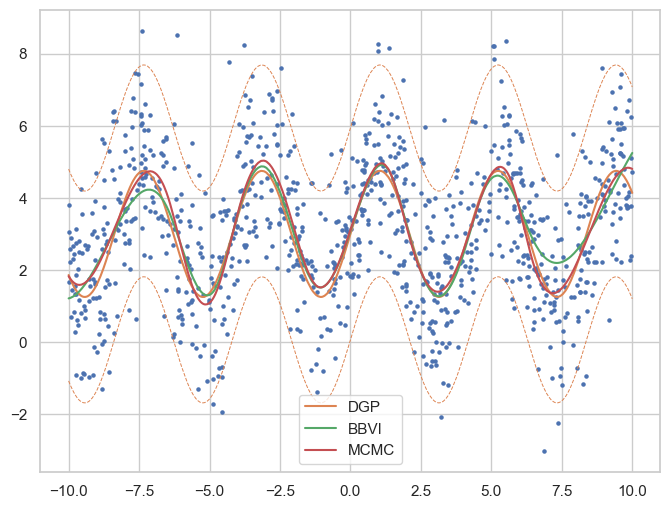

In [35]:
# plot the data
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

plt.scatter(x=sort_df["x"], y=sort_df["y"], s=5)
plt.plot(sort_df["x"], sort_df["loc"], label="DGP", color=sns.color_palette()[1])
plt.plot(sort_df["x"], sort_df["loc"] + 1.96*sort_df["scale"], linewidth=0.7, color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_df["x"], sort_df["loc"] - 1.96*sort_df["scale"], linewidth=0.7, color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y"], color=sns.color_palette()[2], label = "BBVI")
plt.plot(sort_pred_data_lsl["x"], sort_pred_data_lsl["y"], color=sns.color_palette()[3], label = "MCMC")
plt.legend()
plt.show()

sns.reset_orig()

## Compare the posteriors 

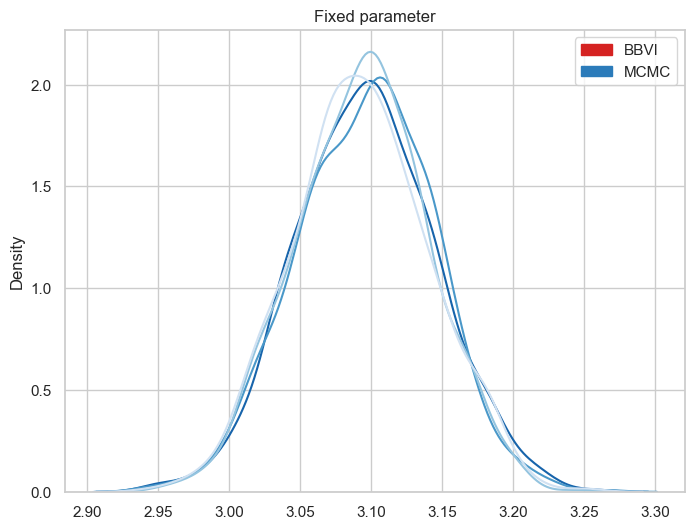

In [36]:
import matplotlib.patches as mpatches

# Squeezing the array to remove single-dimensional entries
squeezed_array = np.squeeze(post_samples["beta"])

# Creating a Pandas DataFrame by specifying columns as the squeezed_array
df = pd.DataFrame(squeezed_array.T, columns=['MCMC_1', 'MCMC_2', 'MCMC_3', 'MCMC_4'])

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

sns.kdeplot(df, palette="Blues", legend=False)
red_patch = mpatches.Patch(color=sns.color_palette("Reds")[4], label='BBVI')
blue_patch = mpatches.Patch(color=sns.color_palette("Blues")[4], label='MCMC')
plt.legend(handles=[red_patch, blue_patch])
plt.title("Fixed parameter")
plt.show()

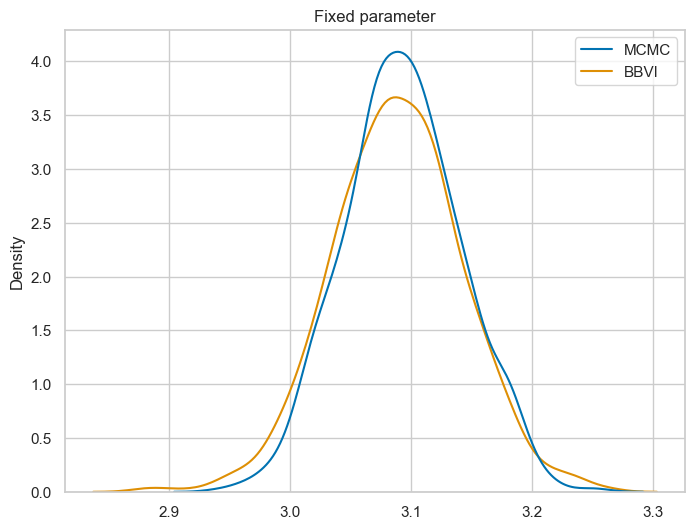

In [37]:
# Fixed parameter 
# BBVI (tiger)
loc, cov = q.trans_var_params["beta"]["loc"], q.trans_var_params["beta"]["cov"]
samples_beta_fixed_tiger = tfjd.Normal(loc=loc, scale=jnp.squeeze(jnp.sqrt(cov))).sample(1000, seed=jax.random.PRNGKey(0))

# MCMC (liesel)
samples_beta_liesel = post_samples["beta"][0,:]

plot_data = pd.DataFrame({"MCMC": jnp.squeeze(samples_beta_liesel), "BBVI": jnp.squeeze(samples_beta_fixed_tiger)})

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

sns.kdeplot(plot_data, palette="colorblind")
plt.title("Fixed parameter")
plt.show()

In [38]:
params_pos = [0, 6, 13, 19]
df = pd.DataFrame(data=np.vstack([post_samples["smooth_1_coef"][:,:,i].T for i in params_pos]), columns=["MCMC_1", "MCMC_2", "MCMC_3", "MCMC_4"])
df["gamma_pos"] = jnp.repeat(jnp.asarray(params_pos), post_samples["smooth_1_coef"].shape[1])

df[df["gamma_pos"]==0]

,MCMC_1,MCMC_2,MCMC_3,MCMC_4,gamma_pos
0,2.032007,2.111533,1.865247,1.862337,0
1,1.958001,1.930344,1.713995,1.984843,0
2,2.018524,1.895314,1.793630,1.719077,0
3,2.018524,1.895314,1.707195,1.717120,0
4,1.895372,1.814001,1.707195,1.678379,0
...,...,...,...,...,...
995,1.397248,1.544560,1.982831,2.097080,0
996,1.642901,1.621749,2.247748,2.127213,0
997,1.695536,1.578604,2.247748,2.331722,0
998,1.695923,1.656487,2.105697,2.084996,0


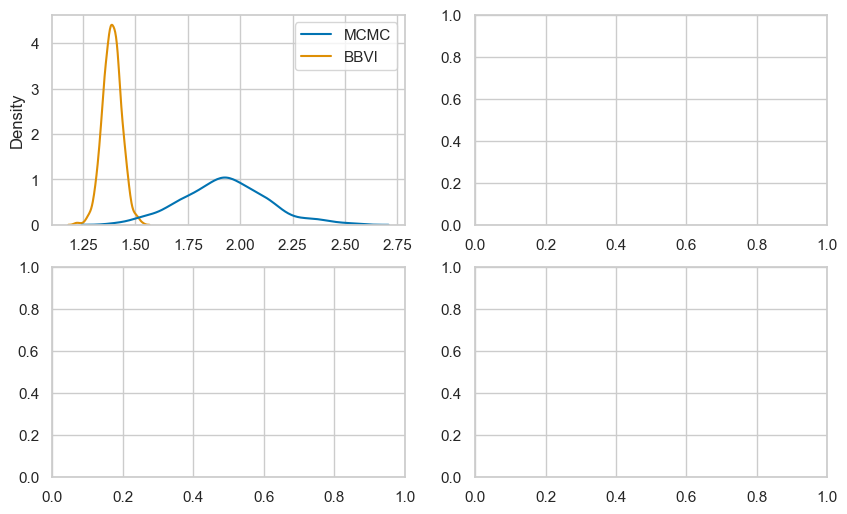

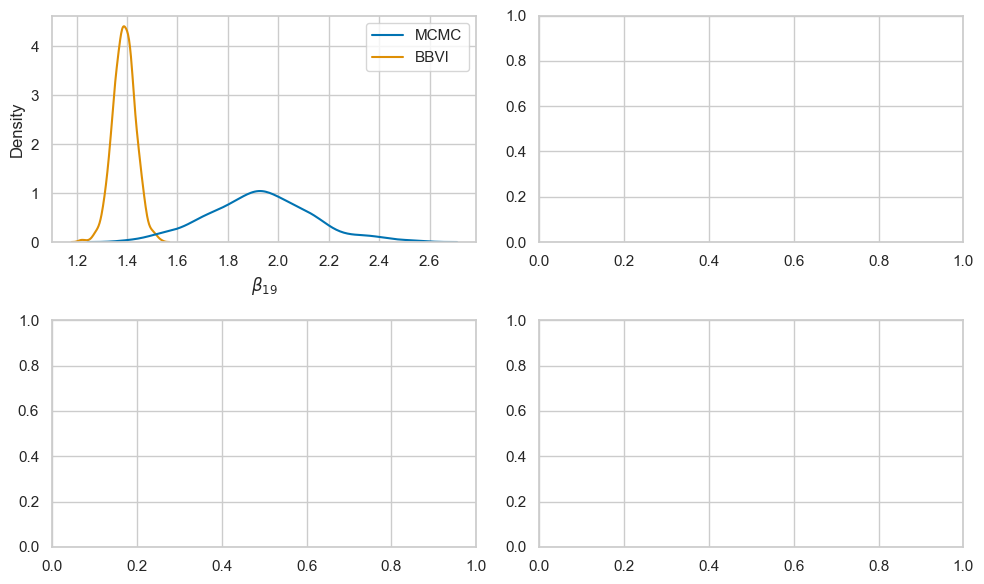

In [56]:
n=0
loc, cov = q.trans_var_params["gamma"]["loc"], q.trans_var_params["gamma"]["cov"]
samples_beta_fixed_tiger = tfjd.Normal(loc=loc[n], scale=jnp.squeeze(jnp.sqrt(cov[n,n]))).sample(1000, seed=jax.random.PRNGKey(0))
samples_beta_liesel = post_samples["smooth_1_coef"][0,:, n]
plot_data = pd.DataFrame({"MCMC": jnp.squeeze(samples_beta_liesel), "BBVI": jnp.squeeze(samples_beta_fixed_tiger)})
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
sns.kdeplot(plot_data, ax=axs[0,0], palette="colorblind")
axs[0,0].set_xlabel(rf"$\beta_{{{str(19)}}}$")
plt.tight_layout()
plt.show()
sns.reset_orig()

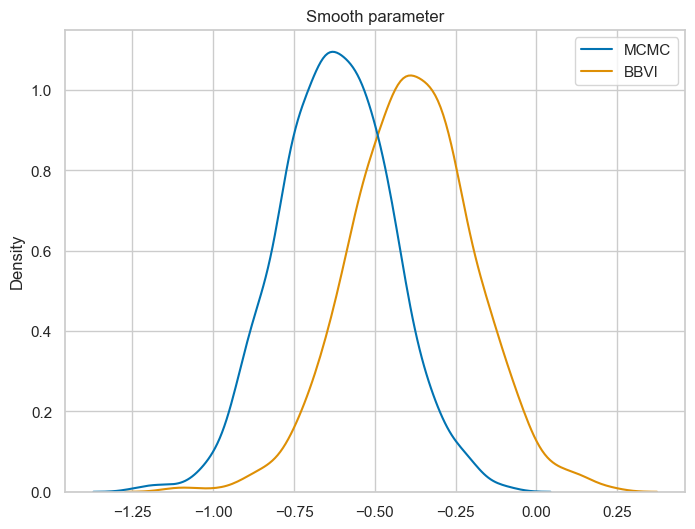

In [66]:
# Smooth parameter 
# choose parameter 
n = 18

# BBVI (tiger)
loc, cov = q.trans_var_params["gamma"]["loc"], q.trans_var_params["gamma"]["cov"]
samples_beta_fixed_tiger = tfjd.Normal(loc=loc[n], scale=jnp.squeeze(jnp.sqrt(cov[n,n]))).sample(1000, seed=jax.random.PRNGKey(0))

# MCMC (liesel)
samples_beta_liesel = post_samples["smooth_1_coef"][0,:, n]

plot_data = pd.DataFrame({"MCMC": jnp.squeeze(samples_beta_liesel), "BBVI": jnp.squeeze(samples_beta_fixed_tiger)})

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

sns.kdeplot(plot_data, palette="colorblind")
plt.title("Smooth parameter")
plt.show()

In [ ]:
from tigerpy.bbvi.transform import (
    log_cholesky_parametrization_to_tril,
    cov_from_prec_chol
)

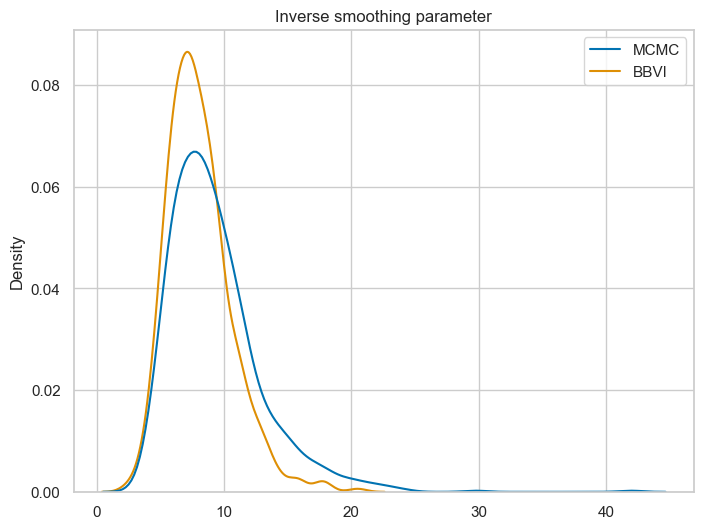

In [69]:
# Inverse smoothing parameter
# BBVI (tiger)
loc = q.var_params["tau2"]["loc"]
lower_tri = log_cholesky_parametrization_to_tril(q.var_params["tau2"]["log_cholesky_prec"], 
                                                 d=loc.shape[0])
cov =  cov_from_prec_chol(lower_tri)

samples_tau_tiger = tfjd.Normal(loc=loc, scale=jnp.squeeze(jnp.sqrt(cov))).sample(1000, seed=jax.random.PRNGKey(0))
samples_tau2_tiger = jnp.exp(samples_tau_tiger)
# MCMC (liesel)
samples_tau2_liesel = post_samples["tau2"][0,:]

plot_data = pd.DataFrame({"MCMC": jnp.squeeze(samples_tau2_liesel), "BBVI": jnp.squeeze(samples_tau2_tiger)})

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

sns.kdeplot(plot_data, palette="colorblind")
plt.title("Inverse smoothing parameter")
plt.show()

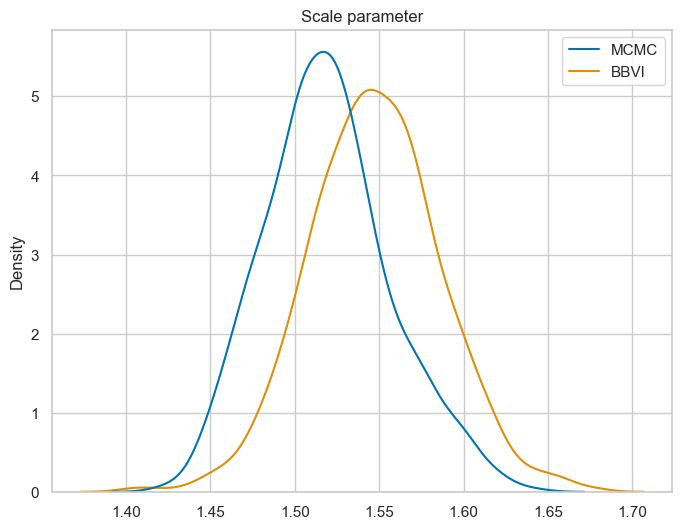

In [71]:
# Scale parameter
# BBVI (tiger)
loc = q.var_params["sigma"]["loc"]
lower_tri = log_cholesky_parametrization_to_tril(q.var_params["sigma"]["log_cholesky_prec"], 
                                                 d=loc.shape[0])
cov =  cov_from_prec_chol(lower_tri)
samples_sigma_tiger = tfjd.Normal(loc=loc, scale=jnp.squeeze(jnp.sqrt(cov))).sample(1000, seed=jax.random.PRNGKey(0))
samples_sigma_tiger = jnp.exp(samples_sigma_tiger)
# MCMC (liesel)
samples_sigma_liesel = post_samples["sigma"][0,:]

plot_data = pd.DataFrame({"MCMC": jnp.squeeze(samples_sigma_liesel), "BBVI": jnp.squeeze(samples_sigma_tiger)})

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

sns.kdeplot(plot_data, palette="colorblind")
plt.title("Scale parameter")
plt.show()